<center><font size=10>Appendix</font></center>
[超链接名](超链接地址）括号必须为英文状态

In [1]:
# Import the lib to support the code
import pickle
import pandas as pd
import networkx as nx
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import collections
import numpy as np
import math

# Task A: Network Metrics

# Draw the graph with no layout

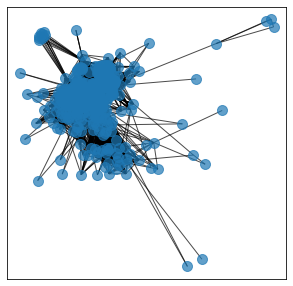

In [2]:
# Convert csv file to hnet_edgelist_df
hnet_edgelist_df = pd.read_csv("./harmonic_net_edgelist.csv")

# Import the dataframe into the graph
# Metion: nx.from_pandas_dataframe is abandoned in Version > 2.1
G_hnet = nx.from_pandas_edgelist(hnet_edgelist_df, "source", "target", ["weight", "lsrp"])
plt.figure(figsize=(5, 5))
nx.draw_networkx(G_hnet,with_labels=False, node_size=100, alpha = 0.7)

# Draw the graph with Kamada_kawai Layout

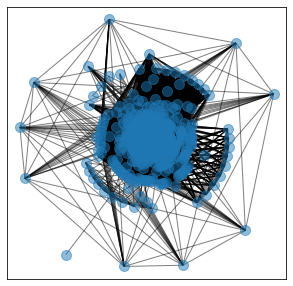

In [3]:
# import the dataframe into the graph
# Metion: nx.from_pandas_dataframe is abandoned in Version > 2.1
G_hnet = nx.from_pandas_edgelist(hnet_edgelist_df, "source", "target", ["weight", "lsrp"])

# Based on path length cost function
pos = nx.kamada_kawai_layout(G_hnet)
plt.figure(figsize=(5,5))
nx.draw_networkx(G_hnet, pos=pos,with_labels=False, alpha = 0.5, node_size=100)
# nx.get_edge_attributes(G_hnet,"weight")

# The attributes of graph

Number of nodes: 520
Number of edges: 31703
Number of connected components: 1
Average degree: 121.93461538461538
Clustering coefficient: 0.7034513652671424
Diameter of the graph: 5


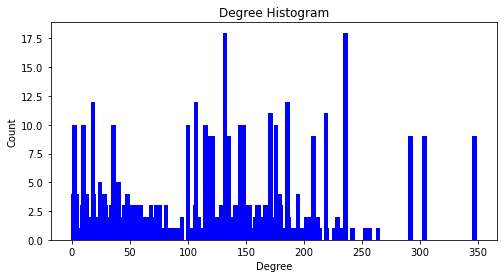

In [4]:
# The function is cited by the codes from https://github.kcl.ac.uk/k2143309/7CUSMNDA/blob/master/notebooks/week_2b.ipynb 
def print_graph_statistics(graph):
    print("Number of nodes: {}\nNumber of edges: {}".format(
        graph.number_of_nodes(), graph.number_of_edges()
    ))
    print("Number of connected components: {}".format(
        nx.algorithms.components.number_connected_components(graph),
    ))
    print("Average degree: {}\nClustering coefficient: {}".format(
        np.mean([deg for _, deg in graph.degree]),
        nx.algorithms.cluster.average_clustering(graph)
    ))
    print("Diameter of the graph: {}".format(
        nx.diameter(graph)
    ))
    degree_sequence = [d for n, d in graph.degree()]
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.bar(deg, cnt, width = 4, color="b")
    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()

print_graph_statistics(G_hnet)

# TaskA Q1: What are the characteristic properties of this song similarity network?

The characteristic properties of this song similarity network is below:
- Number of nodes: 520
- Number of edges: 31703
- Number of connected components: 1
- Average degree: 121.93461538461538
- Clustering coefficient: 0.7034513652671424
- Diameter of the graph: 5

And you can see the distribution of the degree histogram graph is irregular.

# Create a random network (Erdös-Renyi graph)
In order to compare the difference between this harmonic network and the random network, I create a Erdös-Renyi graph to make some analysis.

As expected, no standalone nodes.
Number of nodes: 520
Number of edges: 31456
Number of connected components: 1
Average degree: 120.98461538461538
Clustering coefficient: 0.23341334293433388
Diameter of the graph: 2


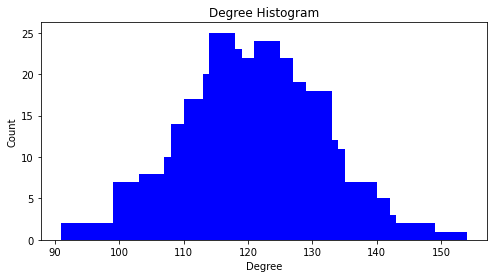

In [5]:
# The probility of each edge is equal to Edges/(n*(n-1)/2)
n = 520
edges = 31703
p = edges / (n * (n-1) / 2)
# Create a random network
G_random = nx.gnp_random_graph(520, p)
# We expect the graph to not contain any isolated nodes and so be connected
def expect_no_isolted(n,p):
    threshold_value = math.log(n) / n
    if p > threshold_value:
        print("As expected, no standalone nodes.")
    else:
        print("Not as expected, contains standalone nodes.")
        
expect_no_isolted(n,p)
print_graph_statistics(G_random)

# TaskA Q2: How different is this network from a random network?

As we all know, the random network has below characteristic:
1. Has a Poisson distribution;
2. The probability of each edge appearing is equal;
3. It belongs to a uniform network (the degree distribution drops sharply in an exponential form, such a network is called a uniform network).

However, this harmonic network doesn't have a Poisson distribution but a irrgular distribution. Definitely, the probability of each edge is not equal, depending on whether there is a weight(similarity) between the two songs. Therefore, this network belongs to non-uniform network.

# TaskA Q3: If you take it to be a complete and representative description of songs played in music festivals and their tendency to become catchy, what does it tell you about the way songs are played and ignite its similar neighbours?

For the way the song spreads, we will study it from two perspectives, the first is the node degree, and the second is the average number of hops of the node.

# Solution1: Get the node that has the max degree
We know that the node with bigger degree has more neighbor nodes, which means that the node could be regarded as a central node. As for a central node, it could make more nodes be ignited, as well as being considered the most influential song.

In [6]:
# Get node with maximum degree
def get_maxdegree(graph):
    maxdegree_node = str()
    maxdegree = 0
    for n in graph.nodes():
        # get the degree of each node
        degree = graph.degree(n)
        if degree>maxdegree:
            maxdegree =  degree
            maxdegree_node = n
        else:
            continue
    return maxdegree_node 

maxdegree_node = get_maxdegree(G_hnet)
print("The node with maximum degree is：", maxdegree_node, ", whose degree is: ", G_hnet.degree(maxdegree_node))
# get the song name
meta_df = pd.read_csv("./sonar_datasets_meta.csv")
print("This song is: ", meta_df[meta_df["id"] == maxdegree_node].title[348])
print("Its artist is: ", meta_df[meta_df["id"] == maxdegree_node].artist[348])

The node with maximum degree is： schubert-winterreise_36 , whose degree is:  347
This song is:  Frühlingstraum
Its artist is:  Thomas Oliemans, Bert van den Brink


Now, we need to take the weight(similarity) into consideration. I set an ignition threshold, and only when the weight exceeds this threshold, the adjacent nodes can be ignited.

In [7]:
# Set ignition threshold
ignite_threshold = 0.6
print("The degree of max degree node is: ",G_hnet.degree(maxdegree_node))
# Creat a null dataframe to store the new dataframe
df = pd.DataFrame()
for n in G_hnet.neighbors(maxdegree_node):
    df1 = hnet_edgelist_df[(hnet_edgelist_df["source"] == maxdegree_node) \
                                    & (hnet_edgelist_df["target"] == n)]
    df2 = hnet_edgelist_df[(hnet_edgelist_df["target"] == maxdegree_node) \
                                    & (hnet_edgelist_df["source"] == n)]
    df1 = pd.concat([df1, df2])
    df = pd.concat([df, df1],ignore_index=True)
# get the new dataframe about the weight > threshold
df3 = df[(df.weight>ignite_threshold)]

The degree of max degree node is:  347


,source,target,weight,lsrp
205,schubert-winterreise_36,schubert-winterreise_55,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
209,schubert-winterreise_36,schubert-winterreise_61,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
253,schubert-winterreise_36,schubert-winterreise_111,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
268,schubert-winterreise_36,schubert-winterreise_128,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
272,schubert-winterreise_36,schubert-winterreise_132,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
307,schubert-winterreise_36,schubert-winterreise_170,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
337,schubert-winterreise_36,schubert-winterreise_203,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."
338,schubert-winterreise_36,schubert-winterreise_205,1.0,"[(35, 238, 147, 106, 131, 238, 147, 106, 227, ..."


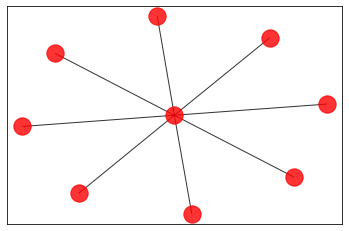

In [8]:
# Draw the picture about how the point with the largest degree ignites the surrounding nodes (songs)
G_maxdegree = nx.from_pandas_edgelist(df3, "source", "target", ["weight", "lsrp"])
plt.figure()
nx.draw_networkx(G_maxdegree,with_labels=False, node_color="r", alpha = 0.8)

Through the above analysis, we can already know how the degree of the node affects the way the song is played and ignited. Here we can set different thresholds and different songs to understand how they affect its neighbors.

Next, we'll consider the effect of the shortest path on how the song plays and ignites.

# Solution2: Calculate the shortest path diameter
Just like the small world network, the spread of music also has the same characteristics. If the chords between two pieces of music have a high similarity, we think that song A will be sung because of similar song B.

First of all, we conduct a study on the most direct way, that is to imitate the Bacon number to do a simple study on the correlation between songs.

   Diameter  Count
1         0      1
0         1    160
2         2    330
3         3     27
4         4      2


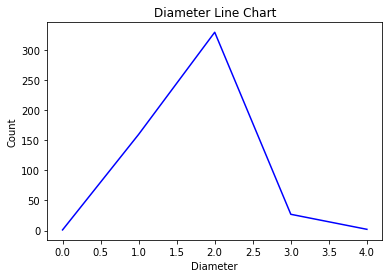

In [9]:
def bacon_number(graph, bacon):
    diameter_sequence = []
    for n in graph.nodes():
        # Because nx.shortest only return a list of nodes not the diameter, so we need n-1
        diameter = len(nx.shortest_path(G_hnet, bacon, n))-1 
        diameter_sequence.append(diameter)
    # Plot the diameter distribution of the graph
    diameterCount = collections.Counter(diameter_sequence)
    dia, cnt = zip(*diameterCount.items())
    dia = list(dia)
    cnt = list(cnt)
    df = {"Diameter" : dia,"Count" : cnt}
    df = pd.DataFrame(df).sort_values(by = "Diameter")
    print(df)
    fig, ax = plt.subplots()
    plt.plot(df["Diameter"],df["Count"],color = "b")
    plt.title("Diameter Line Chart")
    plt.ylabel("Count")
    plt.xlabel("Diameter")
    plt.show()
# Because the graph has only one connected components, so we can choose a famous and popular song as the "Kevin Bacon"
# For example, we take "isophonics_5" as the most famous songs, the picture shows that it is more like a small word network.
bacon_number(G_hnet, "isophonics_5")   

Now, we need to build a function to get the average steps of each node.
And we assume that the node with the smallest average number of steps is the "Kevin Bacon" of our network

In [10]:
# Get the averge steps
def get_avesteps(graph, bacon):
    diameter_sequence = []
    for n in graph.nodes():
        # Because nx.shortest only return a list of nodes not the diameter, so we need n-1
        diameter = len(nx.shortest_path(G_hnet, bacon, n))-1 
        diameter_sequence.append(diameter)
    # Plot the diameter distribution of the graph
    diameterCount = collections.Counter(diameter_sequence)
    dia, cnt = zip(*diameterCount.items())
    dia = list(dia)
    cnt = list(cnt)
    summ = 0
    for n in range(len(dia)):
        summ = summ + dia[n]*cnt[n]
    ave_steps = summ/sum(cnt)
    return ave_steps
smallest_bacon = str()
smallest_steps = 100
for n in G_hnet.nodes():
    new_steps = get_avesteps(G_hnet, n)
    if smallest_steps> new_steps:
        smallest_steps =  new_steps
        smallest_bacon = n
    else:
        continue
        
print("The node which has the smallest average steps to other nodes is: ",smallest_bacon, ", the average steps is: ", smallest_steps)  
meta_df = pd.read_csv("./sonar_datasets_meta.csv")
print("This song is: ", meta_df[meta_df["id"] == smallest_bacon].title[348])
print("Its artist is: ", meta_df[meta_df["id"] == smallest_bacon].artist[348])

The node which has the smallest average steps to other nodes is:  schubert-winterreise_36 , the average steps is:  1.3480769230769232
This song is:  Frühlingstraum
Its artist is:  Thomas Oliemans, Bert van den Brink


From the above analysis, we can know that the average number of hops for the song Frühlingstraum to reach other nodes is 1.348, which means that in this network, it is easier to reach other nodes, which also means that it can affect other nodes faster and ignite them.

So I think this chord similarity network is somewhat of a complete and representative description of the songs played at festivals and their tendency to become catchy.

If in the above chord similarity network, the closer the two songs are, the easier it is to be ignited.A node with a shorter average shortest path is more likely to cause other neighbor nodes (chord-similar songs) to be ignited, because it has the smallest average number of hops to reach other nodes.Meanwhile, we are skeptical that a neighbor node which has a lower weight value(which means lower similarity) may not be ignited efficiently.

The way a song is played and ignited is affected by neighboring nodes, and the smaller the number of average hops, the greater the probability of it being affected and the probability of other songs being played and ignited.

# Task B: Epidemic Models

In [11]:
from ndlib.models import epidemics
import ndlib.models.ModelConfig as config

from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.models.CompositeModel import CompositeModel
from ndlib.models.compartments.NodeStochastic import NodeStochastic
from ndlib.models.compartments.enums.NumericalType import NumericalType
from ndlib.models.compartments.NodeNumericalVariable import NodeNumericalVariable
import ndlib.models.ModelConfig as mc

no display found. Using non-interactive Agg backend


# Task B Q1: If both songs have been played on the same day, how can they use the network data to judge how plausible it is that its catchyness and trend have not propagated yet to neighbouring similar songs?

Here, we create a custom propagation model. We assume that the average weight (similarity) of a node to its adjacent nodes can represent the propagation influence rate of the node, and when the weight exceeds 50%, we consider it to have propagation properties and can quickly and effectively ignite the neighbors.

On average, it ignites some nodes around it, but the trend doesn't continue because there are so few songs played, only 2 out of 520 were selected for playback.

From the resulting images, it can be seen that the transmission stops after a short period of time in the initial stage, and these evidences suggest that playing a small number of songs in a short period does not cause a large-scale transmission of a certain melody.

For the best and worst cases, we used ThresholdModel for model building：
- Our best-case assumption is that a node can be infected when only 1% of its neighbors are infected. This means that the song has a strong appeal, and people can't forget the melody as soon as they hear it.
- Our worst-case assumption is that when 99% of neighboring nodes are infected, nevertheless the node is not yet infected. This means that the song's appeal is so weak that people can barely remember its melody.

From the output images of Case2&3, we can know that in the best case, the chord network is all infected in one cycle; however, in the worst case, almost no contagion event occurs in the chord network.


# Case 1: An average case

In [32]:
# Get the average weight of each node to their neighbors that could be set as the threshold for each node.
def get_average_weight(graph, node):
    df = pd.DataFrame()
    # get the weight of each edge of node
    for n in graph.neighbors(node):
        df1 = hnet_edgelist_df[(hnet_edgelist_df["source"] == node) \
                                        & (hnet_edgelist_df["target"] == n)]
        df2 = hnet_edgelist_df[(hnet_edgelist_df["target"] == node) \
                                        & (hnet_edgelist_df["source"] == n)]
        df1 = pd.concat([df1, df2])
        df = pd.concat([df, df1],ignore_index=True)
        average_weight = df.weight.mean()
        return average_weight

The total number of nodes in the chord network is 520, and now we want to randomly select 2 songs as research objects, that is, choose two objects in the population as infection sources.

In [33]:
# Select two nodes randomly
def random_choice(graph):
    n1 = np.random.choice(graph.nodes())
    n2 = np.random.choice(graph.nodes()) 
    infected_nodes = [n1,n2]
    return infected_nodes

First, we use an independent cascade model to simulate the process of song propagation. However, in the chord similarity network of songs, there is no event of being infected and then recovering, so we define a model to analyze the propagation of the network after this.

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\ndlib\viz\mpl\DiffusionViz.py:89: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


520

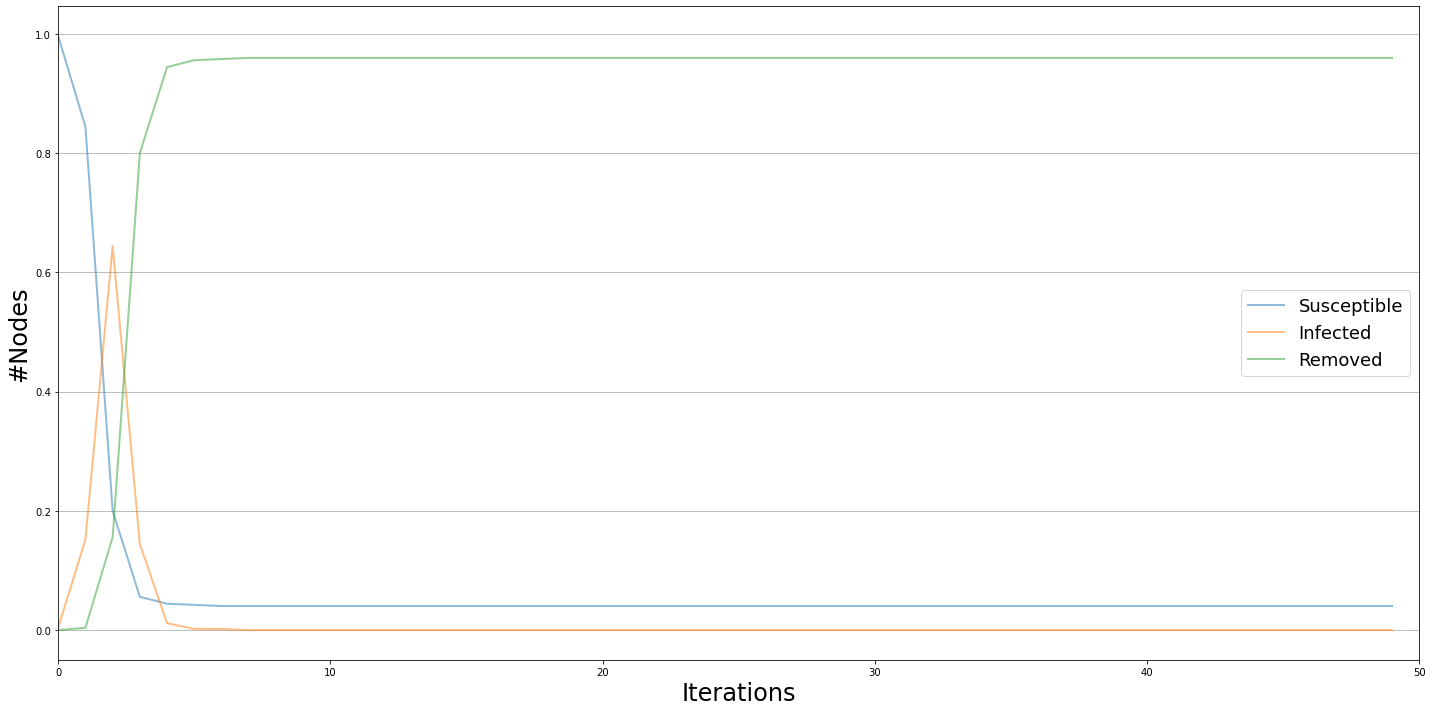

In [34]:
# Model selection
model_test = epidemics.IndependentCascadesModel(G_hnet)

# Model Configuration
config_test = mc.Configuration()
infected_nodes = random_choice(G_hnet)
# Set the initial infected nodes
config_test.add_model_initial_configuration("Infected", infected_nodes)

# Setting the edge parameters
threshold = 0.2
for e in G_hnet.edges():
    config_test.add_edge_configuration("threshold", e, threshold)

model_test.set_initial_status(config_test)

# Simulation execution
iterations_test = model_test.iteration_bunch(50)
trends_test = model_test.build_trends(iterations_test)

# Reference source: https://ndlib.readthedocs.io/en/latest/custom/compartments/NodeNumericalVariable.html

viz = DiffusionTrend(model_test, trends_test)
viz.plot()
G_hnet.number_of_nodes()

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\ndlib\viz\mpl\DiffusionViz.py:89: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


520

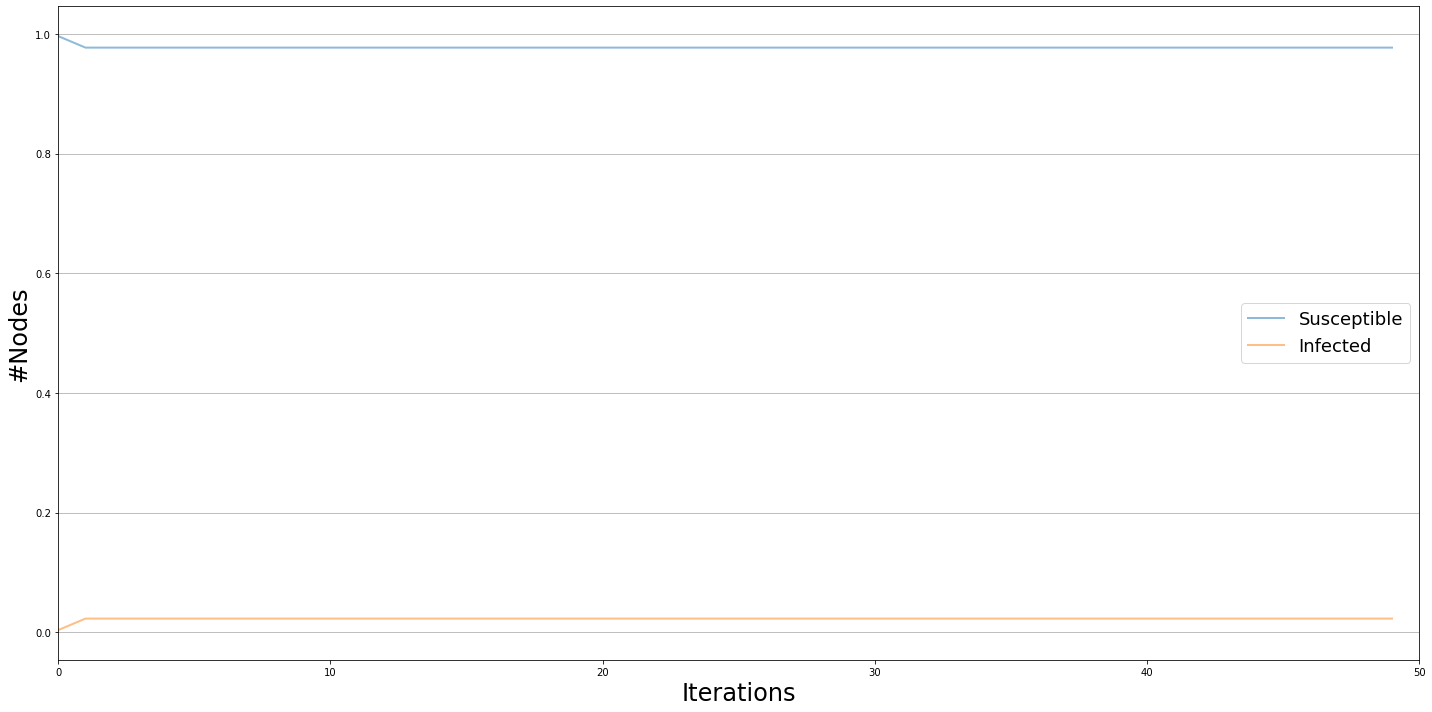

In [35]:
# Setting edge attribute
# Use the average weight for each connected edge to represent node's infection rate.
attr = {n: {"ave_similarity": get_average_weight(G_hnet, n)} for n in G_hnet.nodes()}
nx.set_node_attributes(G_hnet, attr)

# Composite Model instantiation
model = CompositeModel(G_hnet)

# Model statuses
model.add_status("Susceptible")
model.add_status("Infected")

# Compartment definition
# When similarity > the condition value, we can regard the node could be infected.
condition = NodeNumericalVariable('ave_similarity', var_type=NumericalType.ATTRIBUTE, value=0.5, op='>=')

# Rule definition
model.add_rule("Susceptible", "Infected", condition)

# Model initial status configuration
config1 = mc.Configuration()
infected_nodes = random_choice(G_hnet)
# Set the initial infected nodes
config1.add_model_initial_configuration("Infected", infected_nodes)
# Simulation execution
model.set_initial_status(config1)
iterations = model.iteration_bunch(50)
trends = model.build_trends(iterations)

# Reference source: https://ndlib.readthedocs.io/en/latest/custom/compartments/NodeNumericalVariable.html

viz = DiffusionTrend(model, trends)
viz.plot()
G_hnet.number_of_nodes()

We could see that the proportion of susceptible nodes is almost equal to 100% and the infected number is almost equal to 0.
Therefore, in this case, we have enough evidence to judge that its catchy and trend have not yet spread to similar adjacent songs.

# Case 2: Best case

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\ndlib\viz\mpl\DiffusionViz.py:89: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


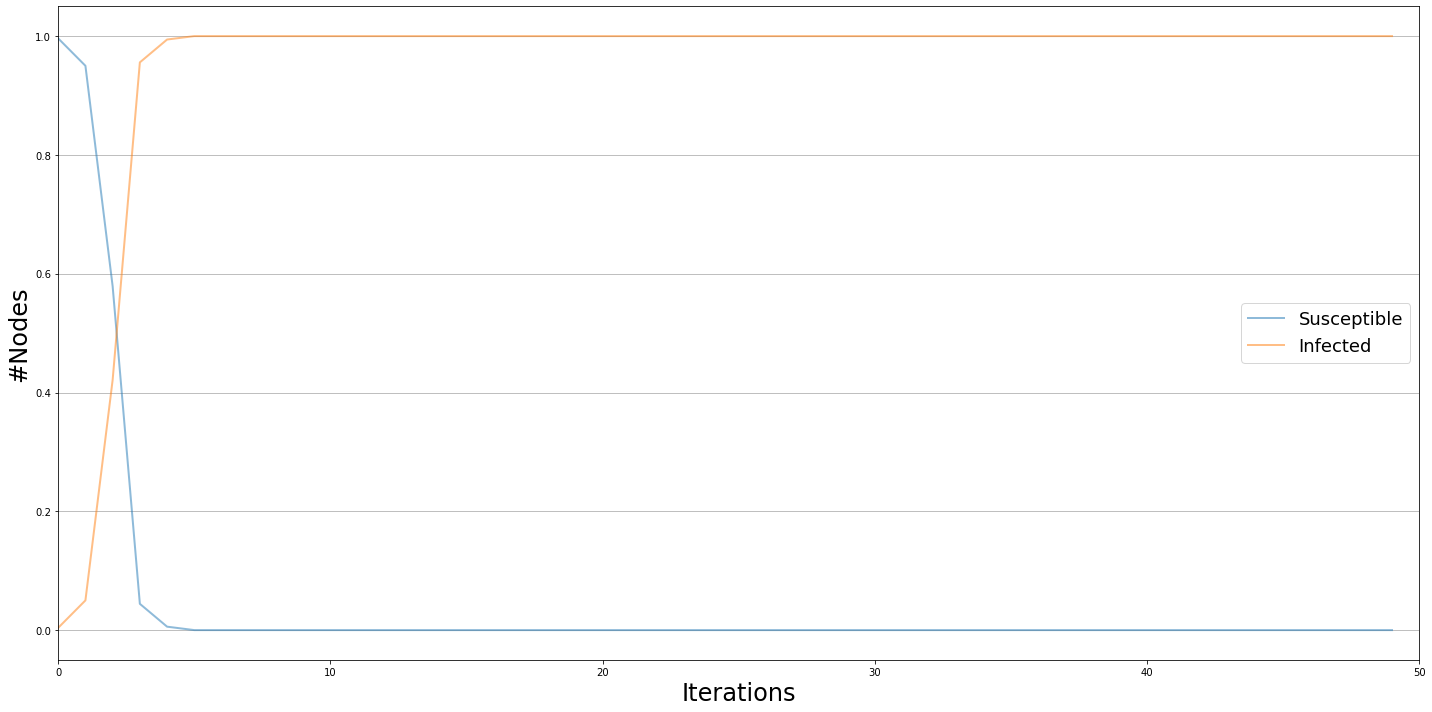

In [36]:
# Build a model in best case
model_best = epidemics.ThresholdModel(G_hnet)
config_best = config.Configuration()
# config1.add_model_parameter('beta', 0.8)
config_best.add_model_parameter("fraction_infected", 2/G_hnet.number_of_nodes())

# In ndlib, each node in the graph has its threshold set individually

for node in G_hnet.nodes():
    # In best case, the threshold for each node is equal to 0 which means the nodes are very contagious.
    threshold = 0.01
    config_best.add_node_configuration("threshold", node, threshold)
# set the initial status of model
model_best.set_initial_status(config_best)
# set the iterations
iterations_best = model_best.iteration_bunch(50)
trends_best = model_best.build_trends(iterations_best)

viz = DiffusionTrend(model_best, trends_best)
viz.plot()

# Case 3: Worst case

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\ndlib\viz\mpl\DiffusionViz.py:89: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


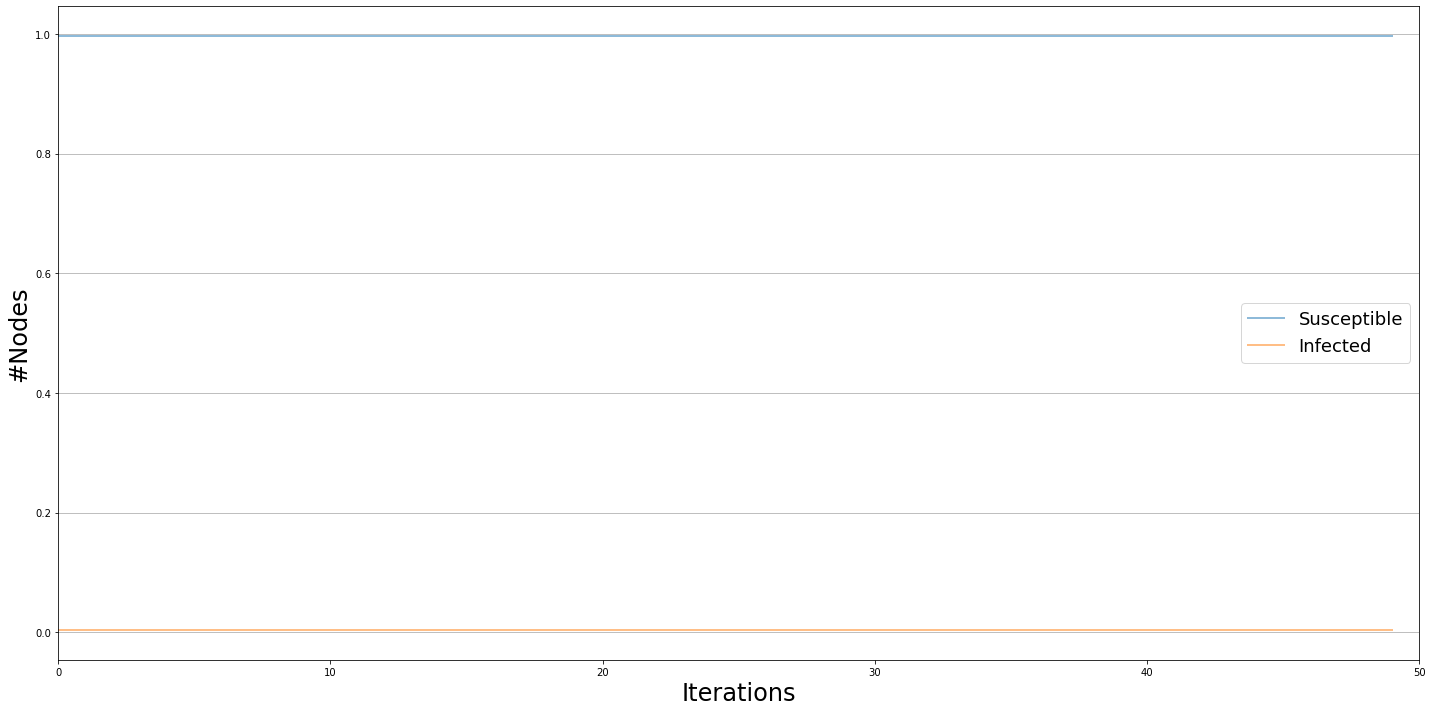

In [37]:
# Build a model in best case
model_worst = epidemics.ThresholdModel(G_hnet)
config_worst = config.Configuration()
config_worst.add_model_parameter("fraction_infected", 2/G_hnet.number_of_nodes())

# In ndlib, each node in the graph has its threshold set individually

for node in G_hnet.nodes():
    # In best case, the threshold for each node is equal to 0 which means the nodes are very contagious.
    threshold = 0.99
    config_worst.add_node_configuration("threshold", node, threshold)
# set the initial status of model
model_worst.set_initial_status(config_worst)
# set the iterations
iterations_worst = model_worst.iteration_bunch(50)
trends_worst = model_worst.build_trends(iterations_worst)

viz = DiffusionTrend(model_worst, trends_worst)
viz.plot()

D:\ProgramData\Anaconda3\envs\msda2021\lib\site-packages\ndlib\viz\mpl\ComparisonViz.py:117: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


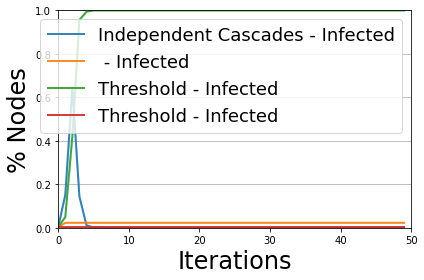

In [38]:
# Higher threshold means slower adoption (infection) and lower stable point
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison

viz = DiffusionTrendComparison(
    [model_test, model, model_best, model_worst], [trends_test, trends, trends_best, trends_worst], statuses = ['Infected'])

viz.plot()

# Task B Q2: If one or both of the tested songs have indeed been played, then the city and the researchers will start checking other songs as well, prioritising those with a higher chance of having been played. How should they use the data to come up with a priority list on what songs to check first?

The priority of song checking should depend on the degree of each song and the average shortest path, we need to find the center point in the network and the "Kevin Bacon" of this network.
Fortunately, we covered this aspect in our previous study of Task A.

The code below gives the ordering of the largest nodes and the ordering of the average shortest path, which allows us to intuitively feel which songs are more infectious in this network.

In addition, we should pay more attention to the neighbors of the selected songs, because the spread of songs often affects their neighbors for the first time.

# Case1: When only one song is selected

The song being selected is:  Mean to Me
   Diameter  Count
3         0      1
2         1     68
0         2    341
1         3    106
4         4      4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_860\3422025207.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


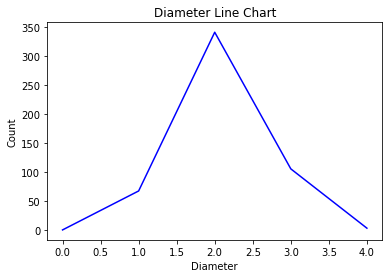

In [19]:
# Let us first consider the shortest path as the criterion for preference, the shorter the path, the more preferred
selected_song = np.random.choice(G_hnet.nodes())
name = meta_df["title"][meta_df["id"] == selected_song].values[0]
print("The song being selected is: ",name)
bacon_number(G_hnet, selected_song) 

Therefore, We'd better first check those points where the path length is 1, that are the neighbors.

Here, we analyze it specifically through the node whose path is 1.
We randomly choose a piece of music, obviously, the shortest path between its neighbors and it is 1, so we analyze this node as the center and analyze how to check its neighbors first.

# Randomly choose a song to play, study the adjacent nodes of this song, and sort by weight.

In [20]:
df = pd.DataFrame()
# get the weight of each edge of node    
for n in G_hnet.neighbors(selected_song):
    df1 = hnet_edgelist_df[(hnet_edgelist_df["source"] == selected_song) & (hnet_edgelist_df["target"] == n)]
    df2 = hnet_edgelist_df[(hnet_edgelist_df["target"] == selected_song) & (hnet_edgelist_df["source"] == n)]
    df1 = pd.concat([df1, df2])
    df = pd.concat([df, df1],ignore_index=True)
# sort the nodes by weight
df = df.sort_values(by="weight",axis=0,inplace=False, ascending = False).reset_index(drop = True)
priority_list = []

for x in range(df.shape[0]):
    priority_dict = { }
    # get source
    df_source = df.iloc[x, 0]
    # get target
    df_target = df.iloc[x, 1]
    # get the neighbors real name
    if df_source == selected_song:
        priority_dict[meta_df["title"][meta_df["id"] == df_target].values[0]]=df.iloc[x, 2]
        priority_list.append(priority_dict)
    else:
        priority_dict[meta_df["title"][meta_df["id"] == df_source].values[0]]=df.iloc[x, 2]
        priority_list.append(priority_dict)
print("The priority list on what songs to check first is below: ")
priority_list

The priority list on what songs to check first is below: 


[{'Potato Head Blues': 0.3850574712643678},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'Der Lindenbaum': 0.2133620689655172},
 {'The Stampede': 0.1253918495297805},
 {'Hotter Than That': 0.1196120689655172},
 {'08_-_Good_Day_Sunshine': 0.1048094373865698},
 {'Misterioso': 0.1034482758620689},
 {'Dinah': 0.1011494252873563},
 {'Body and Soul': 0.0972906403940886},
 {'06_-_Till_There_Was_You': 0.0972906403940886},
 {'Dinah': 0.0972906403940886},
 {'Maple Leaf Rag': 0.0972906403940886},
 {'These Foolish Things': 0.091079460269865},
 {'Dippermouth Blues': 0.091079460269865},
 {'05_-_Your_Mother_Should_Know': 0.0858620689655172},
 {"Wrappin' It Up": 0.0821018062397372},
 {'Body and Soul': 0.0814176245210727},

We check the nodes with high weight first, because they are more similar to the selected song and are more likely to be ignited by it.

# Case2: When two songs are selected

The song being selected is:  03_-_Baby's_In_Black
   Diameter  Count
2         0      1
0         1    229
1         2    271
3         3     17
4         4      2
The song being selected is:  03_-_Flying
   Diameter  Count
2         0      1
0         1    106
1         2    362
3         3     49
4         4      2


C:\Users\ASUS\AppData\Local\Temp\ipykernel_860\3422025207.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_860\3422025207.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


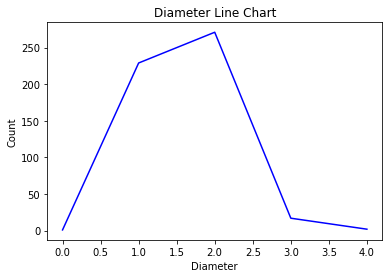

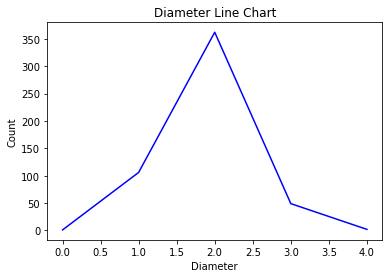

In [21]:
# Select two songs randomly
selected_song1 = np.random.choice(G_hnet.nodes())
selected_song2 = np.random.choice(G_hnet.nodes())
name1 = meta_df["title"][meta_df["id"] == selected_song1].values[0]
name2 = meta_df["title"][meta_df["id"] == selected_song2].values[0]
print("The song being selected is: ",name1)
bacon_number(G_hnet, selected_song1)
print("The song being selected is: ",name2)
bacon_number(G_hnet, selected_song2)

At this time, we still prefer the node with the shortest path as the priority inspection target. At this time, all points with a diameter  1 are taken as priority targets and sorted according to the size of the weight.

In [22]:
df_song1 = pd.DataFrame()
df_song2 = pd.DataFrame()
# get the weight of each edge of node    
for n in G_hnet.neighbors(selected_song1):
    df1_song1 = hnet_edgelist_df[(hnet_edgelist_df["source"] == selected_song1) & (hnet_edgelist_df["target"] == n)]
    df2_song1 = hnet_edgelist_df[(hnet_edgelist_df["target"] == selected_song1) & (hnet_edgelist_df["source"] == n)]
    df1_song1 = pd.concat([df1_song1, df2_song1])
    df_song1 = pd.concat([df_song1, df1_song1],ignore_index=True)

# sort the nodes by weight
for n in G_hnet.neighbors(selected_song2):
    df1_song2 = hnet_edgelist_df[(hnet_edgelist_df["source"] == selected_song2) & (hnet_edgelist_df["target"] == n)]
    df2_song2 = hnet_edgelist_df[(hnet_edgelist_df["target"] == selected_song2) & (hnet_edgelist_df["source"] == n)]
    df1_song2 = pd.concat([df1_song2, df2_song2])
    df_song2 = pd.concat([df_song2, df1_song2],ignore_index=True)
# Merge the neighbor nodes of the two songs to facilitate us to sort by weight
df_song = pd.concat([df_song1, df_song2],ignore_index=True)
df_song = df_song.sort_values(by="weight",axis=0,inplace=False, ascending = False).reset_index(drop = True)
priority_list_two = []
for x in range(df_song.shape[0]):
    priority_dict_two = { }
    # get source
    df_source_two = df_song.iloc[x, 0]
    # get target
    df_target_two = df_song.iloc[x, 1]
    # get the neighbors real name
    if df_source_two == selected_song1:
        priority_dict_two[meta_df["title"][meta_df["id"] == df_target_two].values[0]]=df_song.iloc[x, 2]
        priority_list_two.append(priority_dict_two)
    elif df_target_two == selected_song1:
        priority_dict_two[meta_df["title"][meta_df["id"] == df_source_two].values[0]]=df_song.iloc[x, 2]
        priority_list_two.append(priority_dict_two)
    elif df_source_two == selected_song2:
        priority_dict_two[meta_df["title"][meta_df["id"] == df_target_two].values[0]]=df_song.iloc[x, 2]
        priority_list_two.append(priority_dict_two)
    elif df_target_two == selected_song2:
        priority_dict_two[meta_df["title"][meta_df["id"] == df_source_two].values[0]]=df_song.iloc[x, 2]
        priority_list_two.append(priority_dict_two)
        
print("The priority list on what songs to check first is below: ")
priority_list_two

The priority list on what songs to check first is below: 


[{'07_-_Maggie_Mae': 0.6538461538461539},
 {'07_-_Maggie_Mae': 0.5892857142857143},
 {'07_-_Kansas_City-_Hey,_Hey,_Hey,_Hey': 0.5844155844155844},
 {"CD1_-_14_-_Don't_Pass_Me_By": 0.5654761904761905},
 {'03_-_Flying': 0.5494505494505495},
 {'03_-_Flying': 0.5494505494505495},
 {'04 Home Again': 0.5133928571428572},
 {"12_-_Sgt._Pepper's_Lonely_Hearts_Club_Band_(Reprise)": 0.4903846153846154},
 {'05 I Want To Break Free': 0.4761904761904761},
 {'08_-_Love_Me_Do': 0.4658385093167702},
 {'05_-_Little_Child': 0.4523809523809523},
 {"14_-_Everybody's_Trying_to_Be_My_Baby": 0.4523809523809523},
 {"12_-_I've_Just_Seen_a_Face": 0.4464285714285714},
 {'14_-_Santa_Donna_Lucia_Mobile': 0.4395604395604395},
 {"CD1_-_10_-_I'm_So_Tired": 0.4395604395604395},
 {'14_-_Santa_Donna_Lucia_Mobile': 0.4285714285714285},
 {'14 Hammer To Fall': 0.4265873015873016},
 {'10_-_Lovely_Rita': 0.4247104247104247},
 {'06_-_Let_It_Be': 0.4196428571428571},
 {'07_-_Kansas_City-_Hey,_Hey,_Hey,_Hey': 0.4195804195804196}

From the results we can conclude that: 
- When picking a single song, we first check the node with the shortest path; When checking nodes with the same diameter, we arrange them in order according to the size of the weight. The edge with a large weight means that the two nodes have a high similarity and are more likely to be ignited, so consider checking the node with a large weight first.
- When picking two songs, we first calculate the shortest path from other nodes to these two nodes, and then check the node with the shortest path first.When checking nodes of the same diameter, we merge the data of nodes with the same diameter and sort them by weight. The edge with a large weight means that the two nodes have a high similarity and are more likely to be ignited, so consider checking the node with a large weight first.

# Task C: Interventions

# Task C Q1: How might we use this social network to encourage the adoption of robust checking of played songs?

This chord similarity network studies how songs ignite and spread through similar chords, which allows this network to perform further checks on played songs through some network properties, such as checking the relationship between the spread and chords, and whether songs with similar chords affect each other’s spread.
Based on the attributes of each node and each edge of this social network, when checking songs, selecting the song with the smallest shortest path and the highest weight of the connecting edge will greatly improve the effect of the check, which is easy to find the laws and phenomena that some songs spread according to chords.
We can also consider its contagiousness, which is similar to the independent cascade model. This contagion may be caused by the similarity of chords, or it may be caused by human subjective factors, but in any case, this network provides a theoretical basis and a factual basis for subsequent inspections, which is a great encourage for songs checking.

In social networks, the network nodes are the organizers of music festivals and the heads of streaming media platforms. There is a clear interest relationship and cooperation between them. The streaming media platform publicizes songs through the network, and the organizers of music festivals are responsible for deepening the fans' love of songs and making profits. The edge of the network represents the social relationship between nodes, which enables them to influence each other's investment in songs checking.

The examination of the use of social networks to promote songs is mainly based on two relationships: the relationship between the songwriters and the relationship between the festival organizer and the music streaming platform. If songwriters are close, they may have more overlap in their inspirations and ideas when writing, which may make the songs similar in style (both tend to be love songs), or use the same range of chords in the chorus to express the author's thoughts, which may involve copyright disputes. Costs and risks should be explained when scientists want to check the playing of songs through music festival organizers and music streaming platforms, because in the event of copyright issues of songs, legal disputes may be involved, causing music festivals and media platforms. more significant losses. Checking based on social networks will detect these problems earlier and avoid some songs with copyright risks, which will greatly encourage music festival organizers and streaming platform leaders to support and participate in song checking projects.

# Task C Q2: What interventions could we consider?

In social network, we can also consider whether there is a Triadic closure phenomenon in the network.

This network connects nodes through the relationship between music festival organizer and head of streaming media platform, and they may have the same attitude towards song checking because of peer influence,that is, if A and B have a positive attitude towards song censorship, their mutual friend C may also have a positive attitude towards song censorship.
Similarly, when A and B are fixed, there may be many C1, C2, C3... to form a triangle with edge[A, B], then in cyberspace, there may be multiple co-edge triangles, different organizers will also be affected.

To allow more music festivals and streaming platforms to participate in the song checking project, we apply an influence maximization model in social networks [1]. Here, a hypothesis is proposed that activated individuals transmit their attitudes toward song copyright checks, whether positive or negative, to their neighbors. In some cases, neighbors may further transmit this attitude to their neighbors. Based on this assumption, the number of affected nodes will increase rapidly. However, different initial activation node sets may lead to different propagation efficiencies. What we need to do is to find a set of groups that maximize the influence, and they can make this attitude spread to the maximum extent in the network. We can encourage song checking with the following interventions.

(1) Interventions1:
Reduce testing costs. This could lead to more music festivals or streaming platforms that were refusing to check out songs because of cost issues to begin to turn positive.

(2) Interventions2:
Strictly state the penalties for playing infringing songs, which will create peer pressure, which is conducive to the rapid infection of social networks (because the pressure causes attitude changes).

(3) Interventions3:
Official organizations such as music associations or copyright regulators introduce the social significance, policies and regulations of songs checking through training, and encourage trainees (the collective with the greatest impact) to adopt and practice, thereby driving adjacent peers to implement songs checking together.

(4) Interventions4:
According to the current situation of music dissemination and the adoption of music inspection, the establishment of a reward and punishment system will be adjusted according to different periods.

(5) Interventions5:
Make peers’ compliance more visible.

(6) Interventions6:
Monetary incentives are used, but this may defeat the purpose of musicologists and leave festival organizers with little intrinsic motivation.

(7) Interventions7:
Collecting social network data to resolve blocked or contradictory relationships in the network is conducive to the further expansion of social networks and the contagion of positive attitudes.

(8) Interventions8:
Rewire social networks(re-establish new social relationships), so that non-compliers become socially influenced by compliers. Getting to know a new colleague may lead to a new change in the individual's attitude, because he may learn from the new colleague the seriousness of music copyright infringement.

# Task C Q3: How might we use simulation to test these interventions before implementing them in practice?

Our previous assumption was that when an individual has enough people around him to support songs censorship, the individual will also change attitudes and adopt songs censorship measures. Based on this assumption, we can use the linear threshold model.

With songs that are encouraged to check for this behavior, we want the propagation to reach as many nodes as possible. However, our resources are limited, so we need to decide how to choose a collective (seed set) of nodes so that they can spread the behavior as widely as possible. This is called the influence maximization problem, so we apply the influence maximization model in social networks [2].

In the simulation we constructed, nodes represent a music festival director or a streaming platform director, and the connection of edges means that there is a social relationship between them. In the simulation process, we need to consider the selection of the seed group and the impact of the addition of some intervention conditions. Because I don't have exact data, I can't give a detailed description, but in principle, some of the following specifications need to be followed to get reasonable simulation results.

When determining the choice of seed group, we need to consider two issues: 1. The influencers themselves can be connected, which will waste our limited resources; 2. Two influencers may have strongly overlapping audiences, which will lead to duplication of spread, that means the actual contacts have not increased. Therefore, we adopt the single degree discount method to solve the above problems. The specific logic of the method is: if a node is added to the seed set (e.g. we persuade an influencer), then we reduce the degree of all neighbors of that node by 1 in our ranking. This states that if a node is already in the seed set, then when other nodes are added to the seed set, there should be no effect on that node.

We need to establish some influencing factors (such as checking cost, awareness of copyright issues, frequency of music copyright disputes, etc.), these influencing factors will change due to the addition of interventions, so that the simulation results can be compared. For example, reducing checking costs can make the network more widely spread and nodes more receptive to this behavior.


# Task D: Network Metric-based Quality -Reading Club

# Task D Q1: What kind of problems (bias, identity, etc.) can impact the quality of the network?

Sometimes, two different names in fact denote the same thing: there are many kinds of links that represent the same thing, which can lead to a waste of web resources and can lead to some publications being affiliated with incorrect authors.
The bias of network index will also lead to the decline of network quality, and the decline of clustering coefficient will lead to the problem of network distribution.

# Task D Q2: What network metrics, and combinations thereof, could be effective for assessing link quality and resolving identity?

The quality of the link can be determined according to the connection degree of the node in the network in which it appears. The degree, clustering coefficient and centrality measures are justified as measures of network robustness. Open SameAs chains (fragmentation of the SameAs network is common and thus may be a sign of low quality) and description richness are used to measure fragmentation degree of SameAs network [4].
We can also use the community structure of owl: SameAs graph to detect such statements that may be wrong.


# Redundant code

In [23]:
# Sort the node via the average shortest path
def sort_avepath(graph):
    # get the average value and store it in the list
    path_list = []
    for n in graph.nodes():
        each_path = []
        # get average steps for each node
        new_steps = get_avesteps(graph, n)
        each_path.append(n)
        each_path.append(new_steps)
        path_list.append(each_path)
        
    # sort the degree
    path_list = sorted(path_list, key=lambda x: x[1], reverse=False)    
    index1 = 0
    for n in path_list:
        m = list(n)
        # add some information to the list to make it readable.
        m.append(meta_df["artist"][meta_df["id"] == m[0]].values[0])
        m[0] = meta_df["title"][meta_df["id"] == m[0]].values[0]
        path_list[index1] = m
        index1+=1
    return path_list

# Sort the node via the degree
def sort_degree(graph):
    # sort the degree
    degree_list = sorted(graph.degree, key=lambda x: x[1], reverse=True)
    # Because tuple can modify its inner value, so we change it into list
    index = 0
    for n in degree_list:
        m = list(n)
        # add some information to the list to make it readable.
        m.append(meta_df["artist"][meta_df["id"] == m[0]].values[0])
        m[0] = meta_df["title"][meta_df["id"] == m[0]].values[0]
   
        #dataframe[b][dataframe[a]==1].values[0]
        degree_list[index] = m
        index+=1
    return degree_list